In [4]:
%%capture
!pip install --upgrade pip
!pip install gymnasium[atari] ale-py autorom[accept-rom-license] opencv-python

In [5]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt

In [6]:
import os
from datetime import datetime

In [7]:
import gymnasium as gym
import ale_py
import AutoROM

In [9]:
import torch.nn as nn
import torch
import numpy as np

class ActorCritic(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super().__init__()
        c, h, w = obs_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1), nn.ReLU()
        )

        conv_out_size = self._get_conv_out(obs_shape)

        self.actor = nn.Sequential(
            nn.Linear(conv_out_size, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.critic = nn.Sequential(
            nn.Linear(conv_out_size, 512), nn.ReLU(),
            nn.Linear(512, 1) # Output a single scalar value
        )

    def _get_conv_out(self, shape):
        o = torch.zeros(1, *shape)
        o = self.conv(o)
        return int(np.prod(o.size()))

    def forward(self, x):
        x = x / 255.0  # Normalize pixel values
        conv_out = self.conv(x).view(x.size(0), -1)
        policy_logits = self.actor(conv_out)
        value = self.critic(conv_out)
        return policy_logits, value

print("✅ ActorCritic network class defined successfully!")

✅ ActorCritic network class defined successfully!


In [ ]:
import torch.nn.functional as F

class A2CAgent:
    def __init__(self, obs_shape, n_actions, lr=1e-4, gamma=0.99, entropy_coef=0.01, value_loss_coef=0.5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_loss_coef = value_loss_coef
        self.n_actions = n_actions

        self.model = ActorCritic(obs_shape, n_actions).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        policy_logits, _ = self.model(state) # We only need policy_logits for action selection

        # Get probabilities from logits
        policy = F.softmax(policy_logits, dim=-1)

        # Create categorical distribution
        m = torch.distributions.Categorical(policy)

        # Sample an action
        action = m.sample()

        return action.item()

    def compute_losses(self, states, actions, rewards, next_states, dones):
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).to(self.device)

        # Forward pass through the network
        policy_logits, values = self.model(states)
        _, next_values = self.model(next_states)
        
        target_values = rewards + self.gamma * next_values * (1 - dones)

        advantages = target_values.detach() - values # A = R - V(s)

        policy_dist = torch.distributions.Categorical(logits=policy_logits)
        log_probs = policy_dist.log_prob(actions)
        policy_loss = -(log_probs * advantages.squeeze()).mean()

        value_loss = F.mse_loss(values, target_values.detach())

        entropy_loss = -policy_dist.entropy().mean()

        total_loss = policy_loss + self.value_loss_coef * value_loss + self.entropy_coef * entropy_loss

        return total_loss

    def optimize(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

print("✅ A2CAgent class defined successfully!")

✅ A2CAgent class defined successfully!


In [11]:
def preprocess(obs):
    # Convert RGB (210x160x3) to grayscale + resize (84x84)
    import cv2
    obs_gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs_resized = cv2.resize(obs_gray, (84, 84), interpolation=cv2.INTER_AREA)
    return obs_resized

In [ ]:
def train_beamrider(episodes=600, log_interval=100, save_path="beamrider_a2c.pth"):
    from datetime import datetime
    print("Training started ...!")

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join("runs", f"beamrider_a2c_{run_id}")
    os.makedirs(log_dir, exist_ok=True)
    log_file_path = os.path.join(log_dir, "training_log.csv")

    if not os.path.exists(log_file_path):
        with open(log_file_path, "w") as f:
            f.write("episode,total_reward,avg_reward_10,best_reward\n")

    env = gym.make("BeamRiderNoFrameskip-v4", render_mode=None)
    obs, _ = env.reset()
    obs = preprocess(obs)
    state_shape = (4, 84, 84)
    n_actions = env.action_space.n

    # Instantiate A2CAgent instead of A3CAgent
    agent = A2CAgent(state_shape, n_actions)
    reward_history = []
    best_avg_reward = -float("inf")

    # Frame stack for preprocessing
    frame_stack = deque(maxlen=4)

    for ep in range(episodes):
        states_buffer = []
        actions_buffer = []
        rewards_buffer = []
        next_states_buffer = []
        dones_buffer = []

        obs, _ = env.reset()
        initial_processed_obs = preprocess(obs)
        frame_stack.clear()
        for _ in range(4):
            frame_stack.append(initial_processed_obs)

        total_reward = 0
        done = False

        while not done:
            current_state = np.stack(frame_stack, axis=0)
            action = agent.select_action(current_state)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_processed_obs = preprocess(obs)

            # Create next state for buffer
            next_frame_stack_for_buffer = deque(frame_stack, maxlen=4) # Copy current frame_stack
            next_frame_stack_for_buffer.append(next_processed_obs)
            next_state = np.stack(next_frame_stack_for_buffer, axis=0)

            # Store transition for the trajectory
            states_buffer.append(current_state)
            actions_buffer.append(action)
            rewards_buffer.append(reward)
            next_states_buffer.append(next_state)
            dones_buffer.append(done)

            # Update current frame_stack for next step
            frame_stack.append(next_processed_obs)

            total_reward += reward

        if len(states_buffer) > 0:
            loss = agent.compute_losses(states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer)
            agent.optimize(loss)

        reward_history.append(total_reward)

        recent_rewards = reward_history[-10:] if len(reward_history) >= 10 else reward_history
        avg_r_10 = float(np.mean(recent_rewards))

        is_best = avg_r_10 > best_avg_reward
        if is_best:
            best_avg_reward = avg_r_10
            torch.save({
                "policy_net_state_dict": agent.model.state_dict(),
                "optimizer_state_dict": agent.optimizer.state_dict(),
                "reward_history": reward_history,
                "episode": ep + 1,
                "best_avg_reward": best_avg_reward,
            }, os.path.join(log_dir, "best_model.pth"))

        with open(log_file_path, "a") as f:
            f.write(f"{ep+1},{total_reward},{avg_r_10},{best_avg_reward}\n")

        print(f"Episode {ep+1}: Reward = {total_reward:.1f}, Avg10 = {avg_r_10:.2f}, BestAvg10 = {best_avg_reward:.2f}")

        if (ep + 1) % log_interval == 0:
            ckpt_path = os.path.join(log_dir, f"checkpoint_ep{ep+1}.pth")
            torch.save({
                "policy_net_state_dict": agent.model.state_dict(),
                "optimizer_state_dict": agent.optimizer.state_dict(),
                "reward_history": reward_history,
                "episode": ep + 1,
                "best_avg_reward": best_avg_reward,
            }, ckpt_path)
            print(f"Saved checkpoint to {ckpt_path}")

    env.close()
    plt.plot(reward_history)
    plt.title("A2C on BeamRider-v4")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

Training started ...!


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6641, 6641])) that is different to the input size (torch.Size([6641, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 1: Reward = 440.0, Avg10 = 440.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4973, 4973])) that is different to the input size (torch.Size([4973, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 2: Reward = 440.0, Avg10 = 440.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6057, 6057])) that is different to the input size (torch.Size([6057, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 3: Reward = 440.0, Avg10 = 440.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4387, 4387])) that is different to the input size (torch.Size([4387, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 4: Reward = 132.0, Avg10 = 363.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4160, 4160])) that is different to the input size (torch.Size([4160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 5: Reward = 88.0, Avg10 = 308.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6109, 6109])) that is different to the input size (torch.Size([6109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 6: Reward = 352.0, Avg10 = 315.33, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6167, 6167])) that is different to the input size (torch.Size([6167, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 7: Reward = 396.0, Avg10 = 326.86, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5623, 5623])) that is different to the input size (torch.Size([5623, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 8: Reward = 352.0, Avg10 = 330.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5935, 5935])) that is different to the input size (torch.Size([5935, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 9: Reward = 484.0, Avg10 = 347.11, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6467, 6467])) that is different to the input size (torch.Size([6467, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 10: Reward = 352.0, Avg10 = 347.60, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep10.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6135, 6135])) that is different to the input size (torch.Size([6135, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 11: Reward = 308.0, Avg10 = 334.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5283, 5283])) that is different to the input size (torch.Size([5283, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 12: Reward = 528.0, Avg10 = 343.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4121, 4121])) that is different to the input size (torch.Size([4121, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 13: Reward = 308.0, Avg10 = 330.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5385, 5385])) that is different to the input size (torch.Size([5385, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 14: Reward = 484.0, Avg10 = 365.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5943, 5943])) that is different to the input size (torch.Size([5943, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 15: Reward = 616.0, Avg10 = 418.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4753, 4753])) that is different to the input size (torch.Size([4753, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 16: Reward = 308.0, Avg10 = 413.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6753, 6753])) that is different to the input size (torch.Size([6753, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 17: Reward = 264.0, Avg10 = 400.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([8161, 8161])) that is different to the input size (torch.Size([8161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 18: Reward = 352.0, Avg10 = 400.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7133, 7133])) that is different to the input size (torch.Size([7133, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 19: Reward = 484.0, Avg10 = 400.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3245, 3245])) that is different to the input size (torch.Size([3245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 20: Reward = 132.0, Avg10 = 378.40, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep20.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3749, 3749])) that is different to the input size (torch.Size([3749, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 21: Reward = 176.0, Avg10 = 365.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3911, 3911])) that is different to the input size (torch.Size([3911, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 22: Reward = 176.0, Avg10 = 330.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5059, 5059])) that is different to the input size (torch.Size([5059, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 23: Reward = 440.0, Avg10 = 343.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7138, 7138])) that is different to the input size (torch.Size([7138, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 24: Reward = 572.0, Avg10 = 352.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5779, 5779])) that is different to the input size (torch.Size([5779, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 25: Reward = 352.0, Avg10 = 325.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5901, 5901])) that is different to the input size (torch.Size([5901, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 26: Reward = 352.0, Avg10 = 330.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([9621, 9621])) that is different to the input size (torch.Size([9621, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 27: Reward = 528.0, Avg10 = 356.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5273, 5273])) that is different to the input size (torch.Size([5273, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 28: Reward = 220.0, Avg10 = 343.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4081, 4081])) that is different to the input size (torch.Size([4081, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 29: Reward = 352.0, Avg10 = 330.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4243, 4243])) that is different to the input size (torch.Size([4243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 30: Reward = 220.0, Avg10 = 338.80, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep30.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([8576, 8576])) that is different to the input size (torch.Size([8576, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 31: Reward = 264.0, Avg10 = 347.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4819, 4819])) that is different to the input size (torch.Size([4819, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 32: Reward = 220.0, Avg10 = 352.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6547, 6547])) that is different to the input size (torch.Size([6547, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 33: Reward = 660.0, Avg10 = 374.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3889, 3889])) that is different to the input size (torch.Size([3889, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 34: Reward = 88.0, Avg10 = 325.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6217, 6217])) that is different to the input size (torch.Size([6217, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 35: Reward = 528.0, Avg10 = 343.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6361, 6361])) that is different to the input size (torch.Size([6361, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 36: Reward = 352.0, Avg10 = 343.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4861, 4861])) that is different to the input size (torch.Size([4861, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 37: Reward = 220.0, Avg10 = 312.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6327, 6327])) that is different to the input size (torch.Size([6327, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 38: Reward = 264.0, Avg10 = 316.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6257, 6257])) that is different to the input size (torch.Size([6257, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 39: Reward = 308.0, Avg10 = 312.40, BestAvg10 = 440.00
Episode 40: Reward = 220.0, Avg10 = 312.40, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep40.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5965, 5965])) that is different to the input size (torch.Size([5965, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 41: Reward = 352.0, Avg10 = 321.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4063, 4063])) that is different to the input size (torch.Size([4063, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 42: Reward = 220.0, Avg10 = 321.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5237, 5237])) that is different to the input size (torch.Size([5237, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 43: Reward = 176.0, Avg10 = 272.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6429, 6429])) that is different to the input size (torch.Size([6429, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 44: Reward = 308.0, Avg10 = 294.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5889, 5889])) that is different to the input size (torch.Size([5889, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 45: Reward = 308.0, Avg10 = 272.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5634, 5634])) that is different to the input size (torch.Size([5634, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 46: Reward = 440.0, Avg10 = 281.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5735, 5735])) that is different to the input size (torch.Size([5735, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 47: Reward = 176.0, Avg10 = 277.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6561, 6561])) that is different to the input size (torch.Size([6561, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 48: Reward = 220.0, Avg10 = 272.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5547, 5547])) that is different to the input size (torch.Size([5547, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 49: Reward = 352.0, Avg10 = 277.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4827, 4827])) that is different to the input size (torch.Size([4827, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 50: Reward = 132.0, Avg10 = 268.40, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep50.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5629, 5629])) that is different to the input size (torch.Size([5629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 51: Reward = 264.0, Avg10 = 259.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6261, 6261])) that is different to the input size (torch.Size([6261, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 52: Reward = 352.0, Avg10 = 272.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6001, 6001])) that is different to the input size (torch.Size([6001, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 53: Reward = 220.0, Avg10 = 277.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4109, 4109])) that is different to the input size (torch.Size([4109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 54: Reward = 176.0, Avg10 = 264.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4707, 4707])) that is different to the input size (torch.Size([4707, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 55: Reward = 176.0, Avg10 = 250.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7025, 7025])) that is different to the input size (torch.Size([7025, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 56: Reward = 308.0, Avg10 = 237.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5147, 5147])) that is different to the input size (torch.Size([5147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 57: Reward = 220.0, Avg10 = 242.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6810, 6810])) that is different to the input size (torch.Size([6810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 58: Reward = 264.0, Avg10 = 246.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4225, 4225])) that is different to the input size (torch.Size([4225, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 59: Reward = 88.0, Avg10 = 220.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4470, 4470])) that is different to the input size (torch.Size([4470, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 60: Reward = 308.0, Avg10 = 237.60, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep60.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6229, 6229])) that is different to the input size (torch.Size([6229, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 61: Reward = 352.0, Avg10 = 246.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5758, 5758])) that is different to the input size (torch.Size([5758, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 62: Reward = 528.0, Avg10 = 264.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7549, 7549])) that is different to the input size (torch.Size([7549, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 63: Reward = 176.0, Avg10 = 259.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4743, 4743])) that is different to the input size (torch.Size([4743, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 64: Reward = 220.0, Avg10 = 264.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5239, 5239])) that is different to the input size (torch.Size([5239, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 65: Reward = 176.0, Avg10 = 264.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5085, 5085])) that is different to the input size (torch.Size([5085, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 66: Reward = 88.0, Avg10 = 242.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3842, 3842])) that is different to the input size (torch.Size([3842, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 67: Reward = 220.0, Avg10 = 242.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3697, 3697])) that is different to the input size (torch.Size([3697, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 68: Reward = 132.0, Avg10 = 228.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6430, 6430])) that is different to the input size (torch.Size([6430, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 69: Reward = 220.0, Avg10 = 242.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5947, 5947])) that is different to the input size (torch.Size([5947, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 70: Reward = 264.0, Avg10 = 237.60, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep70.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4983, 4983])) that is different to the input size (torch.Size([4983, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 71: Reward = 132.0, Avg10 = 215.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7734, 7734])) that is different to the input size (torch.Size([7734, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 72: Reward = 396.0, Avg10 = 202.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4693, 4693])) that is different to the input size (torch.Size([4693, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 73: Reward = 264.0, Avg10 = 211.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4821, 4821])) that is different to the input size (torch.Size([4821, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 74: Reward = 132.0, Avg10 = 202.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6137, 6137])) that is different to the input size (torch.Size([6137, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 75: Reward = 484.0, Avg10 = 233.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6055, 6055])) that is different to the input size (torch.Size([6055, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 76: Reward = 352.0, Avg10 = 259.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3213, 3213])) that is different to the input size (torch.Size([3213, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 77: Reward = 220.0, Avg10 = 259.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5639, 5639])) that is different to the input size (torch.Size([5639, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 78: Reward = 308.0, Avg10 = 277.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4177, 4177])) that is different to the input size (torch.Size([4177, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 79: Reward = 308.0, Avg10 = 286.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4174, 4174])) that is different to the input size (torch.Size([4174, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 80: Reward = 132.0, Avg10 = 272.80, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep80.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4505, 4505])) that is different to the input size (torch.Size([4505, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 81: Reward = 220.0, Avg10 = 281.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4288, 4288])) that is different to the input size (torch.Size([4288, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 82: Reward = 220.0, Avg10 = 264.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6643, 6643])) that is different to the input size (torch.Size([6643, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 83: Reward = 528.0, Avg10 = 290.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7215, 7215])) that is different to the input size (torch.Size([7215, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 84: Reward = 308.0, Avg10 = 308.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4379, 4379])) that is different to the input size (torch.Size([4379, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 85: Reward = 308.0, Avg10 = 290.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7301, 7301])) that is different to the input size (torch.Size([7301, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 86: Reward = 528.0, Avg10 = 308.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5692, 5692])) that is different to the input size (torch.Size([5692, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 87: Reward = 220.0, Avg10 = 308.00, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([9699, 9699])) that is different to the input size (torch.Size([9699, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 88: Reward = 804.0, Avg10 = 357.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6314, 6314])) that is different to the input size (torch.Size([6314, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 89: Reward = 220.0, Avg10 = 348.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7153, 7153])) that is different to the input size (torch.Size([7153, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 90: Reward = 484.0, Avg10 = 384.00, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep90.pth


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7886, 7886])) that is different to the input size (torch.Size([7886, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 91: Reward = 484.0, Avg10 = 410.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5603, 5603])) that is different to the input size (torch.Size([5603, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 92: Reward = 308.0, Avg10 = 419.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7027, 7027])) that is different to the input size (torch.Size([7027, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 93: Reward = 572.0, Avg10 = 423.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([7785, 7785])) that is different to the input size (torch.Size([7785, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 94: Reward = 440.0, Avg10 = 436.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5238, 5238])) that is different to the input size (torch.Size([5238, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 95: Reward = 264.0, Avg10 = 432.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([4663, 4663])) that is different to the input size (torch.Size([4663, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 96: Reward = 176.0, Avg10 = 397.20, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([3187, 3187])) that is different to the input size (torch.Size([3187, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 97: Reward = 176.0, Avg10 = 392.80, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([6205, 6205])) that is different to the input size (torch.Size([6205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 98: Reward = 572.0, Avg10 = 369.60, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5957, 5957])) that is different to the input size (torch.Size([5957, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 99: Reward = 528.0, Avg10 = 400.40, BestAvg10 = 440.00


/tmp/ipython-input-3806254161.py:54: UserWarning: Using a target size (torch.Size([5130, 5130])) that is different to the input size (torch.Size([5130, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target_values.detach())


Episode 100: Reward = 308.0, Avg10 = 382.80, BestAvg10 = 440.00
Saved checkpoint to runs/beamrider_a2c_20251120_190456/checkpoint_ep100.pth


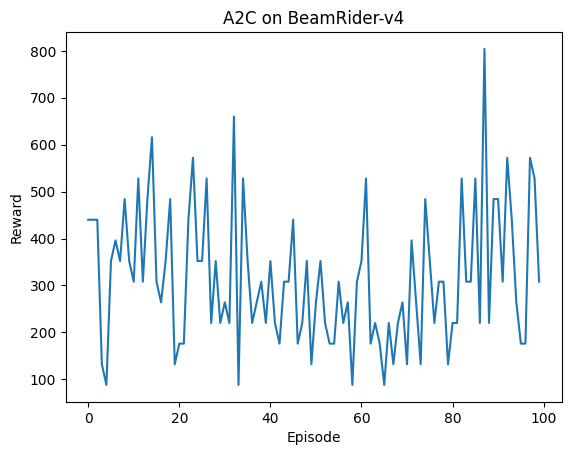

In [ ]:
train_beamrider(episodes = 600)